<a href="https://colab.research.google.com/github/eunsun53/ML_proj/blob/main/KoBERT_pytorch_project_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EA%B0%90%EC%A0%95%EB%B6%84%EB%A5%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KoBERT 모델을 이용한 감정 분류기 프로젝트 


>* KoBERT: SKTbrain 에서 개발한 한국어 특화된 기계번역 BERT 모델
> * Fine-tuning을 이용해 도메인의 데이터를 출력층에서 학습시켜 내가 원하는 목적으로 사용하고자 한다
> * 데이터셋은 한국어 챗복 데이터로, 일상(0), 이별/부정(1), 사랑/긍정(3) 3개의 라벨로 분류된 데이터를 사용함 
> [데이터 깃허브]( https://github.com/songys/Chatbot_data )

In [ ]:
!pip install maxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers == 3.0.2
!pip install torch

In [ ]:
# kobert 다운로드
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [ ]:
import torch 
from torch import nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data improt Dataset, DataLoader
import gluonnlp as nlp 
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
# kober 모델과 토크나이저 생성을 위한 매소드  
from kober.utils import get_tokenizer
from kober.pytorch_kober import get_pytorch_kober_model 

# transformer 패키지 
from transformers import Adam\
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# GPU
devide = torch.device("cuda:0")

# TPU


# 1. 데이터 로드 및 전처리 

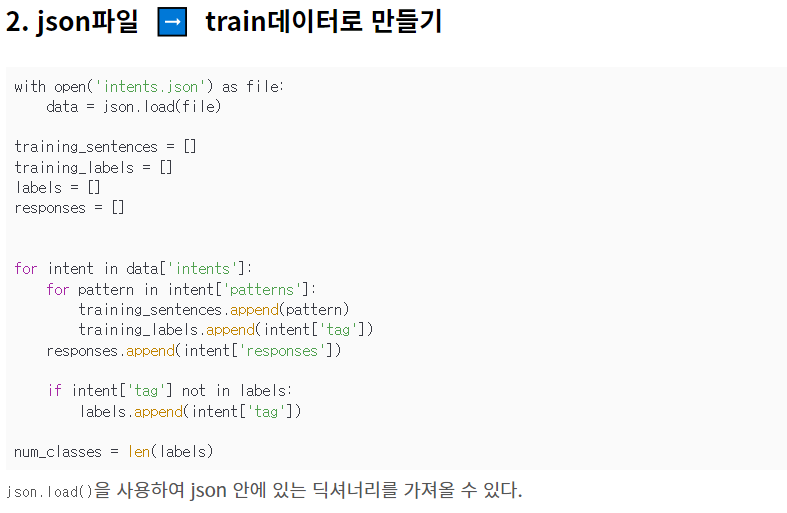

참고 - https://mingtory.tistory.com/117

In [ ]:
import urllib.request 

urllib.request.urlretrieve("https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv", filename = "data.csv")

In [ ]:
data = pd.read_csv("data.csv")
data[:5]

In [ ]:
# 데이터의 'Q'와 'label' 열만 사용 
data_list = []
for q, label in zip(data['Q'], data['label']):
  tmp = []
  tmp.append(q)
  tmp.append(str(label))

  data_list.append(tmp)

print(data_list[:3]) # [문장, label] 로 이루어진 데이터셋이 만들어짐 

In [ ]:
# 훈련, 테스트 집합 나누기 
from sklearn.model_selection import train_test_split

train_data , test_data = train_test_split(data_list, test_size = 0.25, random)
print("train data size: ",len(train_data))
print("test data size: ", len(test_data))

In [ ]:
# 모델에 넣기 위한 데이터 처리 - 토큰화 및 인코딩, 길이 맞추기, 패딩 
class BERTDataset(dataset):
  def __init__(self, dataset, q_idx, label_idx, bert_tokenizer, max_len, pad, pair):
    transform = nlp.data.BERTSentenceTransform(
        bert_tokenizer, max_seq_length = max_len, pad = pad, pair = pair
    )
    self.sentences = [transform([i[q_idx]]) for i in dataset] #데이터셋의 "Q" 문장들 집합 
    self.labels = [np.int32(i[label_idx]) for i in dataset] #데이터셋의 label 집합 

    def __getitem__(self, i):
      return (self.sentences[i]+ (self.labels[i], ))
    
    def __len__(self):
      return len(self.labels)


In [ ]:
# pre-trained된 kober 모델과 그 단어집합 불러오기 
bertmodel, vocab = get_pytorch_kobert_model() 

In [ ]:
#하이퍼파라미터 세팅
max_len = 64 # 데이터 분석한 뒤 실험적으로 구함 
batch_size = 64
warmuo_ratio = 0.1
num_epochs = 5
log_interval = 200
learning_rate = 5e-5

# 토크나이저 생성 
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

# 데이터 전처리 및 인코딩
# token id, 유효길이, segment id, label 리턴   
data_train = BERTDataset(train_dataset, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test_dataset, 0, 1, tok, max_len, True, False)

In [ ]:
train_data[0]

In [ ]:
# torch 형식으로 변환 
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size, num_workers = 5)

In [ ]:
train_dataloader

# 2. KoBERT 학습 모델 만들기 

In [ ]:
class BERTClassifier(nn.Module):  # torch.nn.Module 상속 받음  
  def __init__(self,
               bert,
               hidden_size = 768,
               num_classes = 3, # 분류 라벨 갯수 
               dr_rate = None,
               parama = None):
    super(BERTClassifier, self).__init__() # super(파생클래스, self).__init__() 부모 클래스 초기화 및 받아오겠다는 선언   
    self.bert = bert
    self.dr_rate = dr_rate

    #레이어 
    self.classifier = nn.Linear(hidden_size, num_classes)
    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate )

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    
    return attention_mask.float()

  #forward 함수는 클래스 생성하면 자동으로 실행됨 
  def forward(self. token_ids, valid_length, segment_ids): # forward 함수는 반드시 override 해줘야함
    attention_mask = self.gen_attention_mask(token_ids, valid_length)
    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))

    if self.dr_rate:
      out = self.dropout(pooler)

    return self.classifier(out)


In [ ]:
model = BERTClassifier(bertmodel, dr_rate = 0.5).to(device) # model.to(device) : GPU 사용

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = Adam\(optimizer_grouped_parameters, lr = learning_rate )
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)


In [ ]:
# 정확도 측정 함수 
def clac_accuracy(x, y):
  max_vals, max_indices = torch.max(x,1)
  train_acc = (max_indices == y).sum().data.cpu().numpy()/max_idiced.size()[0]
  return train_acc


# 3. 학습하기 

In [ ]:
for e in range(num_epochs):
  train_acc = 0 
  test_acc = 0
  model.train()  # train mode
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
    optimizer.zero_grad()
    token_ids = token_ids.long().to(device)
    valid_length = valid_length 
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    loss = loss_fn(out, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()
    train_acc += calc_accuracy(out, label)
    if batch_id % log_interval == 0:
      print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval() # evaluate mode
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, test_acc / (batch_id+1)))

# 4. 실제 테스트 


>훈련시킨 모델로 새로운 문장에 대한 감정 분류 기능 테스트

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

In [ ]:
def predict(predict_sentence):
  data = [predict_sentence, '0'] # BERTDataset() 에 넣어서 문장을 토큰화할 수 있도록 입력행태 바꾸기 
  dataset_another = [data]
  another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False) # 토큰화 및 전처리 
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers= 5) # torch 형태로 변환 

  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)
    
    out = model(token_ids, valid_length, segment_ids)

    test_eval = []
    for i in out:
      logits = i
      logits = logits.datch().cpu().numpy()

      #일상(0), 이별/부정(1), 사랑/긍정(3)
      if np.argmax(logits) == 0:
        test_eval.appent('일상적')
      elif np.argmax(logits) == 1:
        test_eval.append('이별/부정')
      elif np.argmax(logits) == 2:
        test_eval.appent('사랑/긍정')
      
    print(">>현재 감정 상태는 "+test_eval[0]+"이시군요")


In [ ]:
end = 1
while end ==1:
  sentence = input("문장을 입력해주세요: ")
  if sentence == 0:
    break 
  predict(sentnece)


참고자료- https://www.dinolabs.ai/271